In [21]:
import os
import torch
import numpy as np
import pickle
import mne
import scipy
from scipy.signal import welch
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler

In [29]:
shape = 31*100
bias = np.tril(np.ones((shape, shape))).astype(np.bool8)
bias = bias.reshape(1, 1, shape, shape)

In [30]:
C = 31

# update self.bias to include custom attention mask
I, J = np.meshgrid(np.arange(bias.shape[-2]), np.arange(bias.shape[-1]), indexing='ij')

mask = ((J % C) <= (I % C)) & (J > I - C) & (J % C != 0)
bias[:, :, mask] = False

In [47]:
bias[0, 0, 96, :100]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False])

In [16]:
# load event timings
path = os.path.join('/', 'well', 'woolrich', 'projects', 'cichy118_cont', 'preproc_data_osl', 'subj1', 'event_times.npy')
event_times = np.load(path)

In [17]:
event_times = [(int(ev[0]/10) - 155520, ev[2]) for ev in event_times]

In [18]:
event_times = [(ev[0], ev[1]) for ev in event_times if ev[0] > 0]

In [21]:
event_times[-1]

(362007, 11)

In [36]:
# epoch mat based on event times
epochs = [[] for i in range(118)]
for e in event_times:
    epochs[e[1] - 1].append(mat[:, e[0]-10:e[0] + 50])


In [45]:
len(epochs[0])

21

In [46]:
epochs = np.array([np.array(e[:20]) for e in epochs])

In [47]:
epochs.shape

(118, 20, 306, 50)

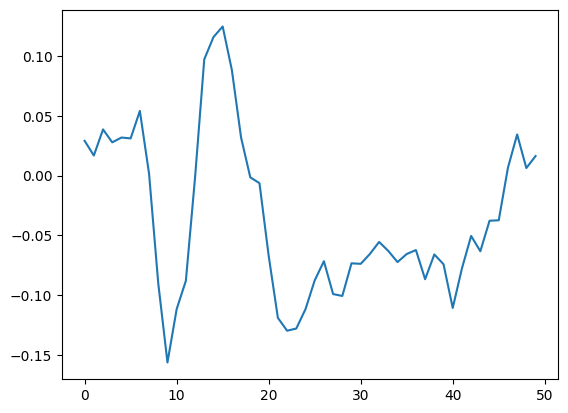

In [53]:
# plot epochs
plt.plot(np.mean(epochs, axis=(0,1))[102])
e=0

In [9]:
# prepare data for matlab
path = os.path.join('/', 'well', 'woolrich', 'projects', 'cichy118_cont', 'preproc_data_osl', 'subj1', 'subj1_50hz.npy')
data = np.load(path)

for f in ['100']:
    # downsample
    mat = data[:, ::int(1000 / int(f))]

    # choose last 3600 seconds
    mat = mat[:, -int(0.7*mat.shape[1]):]

    # apply RobustScaler
    mat = RobustScaler().fit_transform(mat.T).T

    # save as .mat file
    np.save(os.path.join('/', 'well', 'woolrich', 'projects', 'cichy118_cont', 'preproc_data_osl', 'subj1', f'osl_dynamics{f}hz.npy'), mat)

In [20]:
mat.shape

(306, 362880)

In [2]:
path = os.path.join('/', 'well', 'woolrich', 'projects', 'cichy118_cont', 'preproc_data_osl', 'subj1', 'subj1.npy')
data = np.load(path)
data.shape

(306, 5184000)

In [3]:
# filter data
data = mne.filter.filter_data(data, 1000, 1, 49.9, method='iir', iir_params=dict(order=5, ftype='butter'))

Setting up band-pass filter from 1 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 1.00, 49.90 Hz: -6.02, -6.02 dB



In [ ]:
# save data
np.save(path.split('.npy')[0] + '_50hz.npy', data)

# generation visu

In [13]:
def mulaw_inv(x, mu=255):
    x = (x - 0.5) / mu * 2 - 1
    x = np.sign(x)*((1+mu)**np.abs(x)-1)/mu

    return x

In [11]:
path = os.path.join('..', 'results', 'simulated', 'quantized_wavenet', '8event_snr1', 'wavenetfullchannel', 'generated_datarecursive1.mat')
data = loadmat(path)['X'][0]

In [ ]:
path = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'cont_quantized', 'wavenetfullchannelmix_50hz100hz', 'generated_datarecursiveargmax1.mat')
data = loadmat(path)['X']

: 

In [18]:
data = mulaw_inv(data)

In [51]:
t = torch.Tensor([0, 1, 2])
np.random.shuffle(t)
t

tensor([0., 0., 1.])

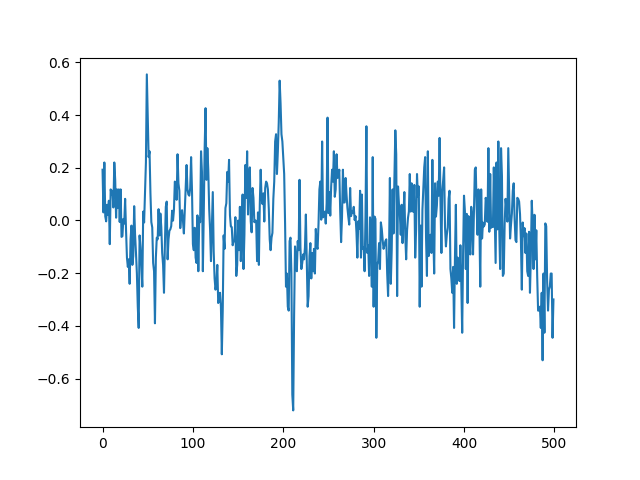

In [30]:
%matplotlib widget
plt.plot(data[10, :500])

(0.0, 0.001)

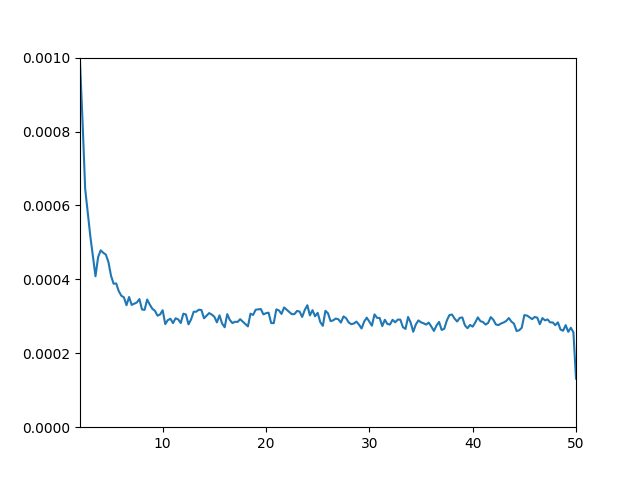

In [27]:
%matplotlib widget
SR = 100
f, Pxx_den = welch(data[120], SR, nperseg=4*SR)

plt.plot(f, Pxx_den)

plt.xlim(2, 50)
plt.ylim(0, 0.001)

#for freq in [10, 14, 18, 22, 26, 33, 38, 45]:
#    plt.axvline(x=freq, color='red')

# Simulation visu

In [ ]:
gamma = np.random.gamma(10, 40, 10000)

%matplotlib widget
plt.hist(gamma, bins=100)
e=0

In [ ]:
path = os.path.join('..', 'results', 'simulated', 'quantized_wavenet', '8event_snr1_1000hz', 'data.mat')
data = loadmat(path)
data['X'].shape

In [ ]:
data = mne.filter.filter_data(data['X'], 1000, 1, 99.9, method='iir', iir_params=dict(order=5, ftype='butter'))

In [ ]:
# save data
path = os.path.join('..', 'results', 'simulated', 'quantized_wavenet', '8event_snr1_1000hz', 'data_sub.npy')
np.save(path, data)

In [ ]:
path = os.path.join('..', 'results', 'simulated', 'quantized_wavenet', '8event_snr1', 'data_sub.npy')
data = np.load(path)

In [ ]:
data.shape

In [ ]:
path = os.path.join('..', 'results', 'simulated', '8event_snr1_wavenetfullquantized', 'stc')
with open(path, 'rb') as f:
    stc = pickle.load(f)

In [ ]:
%matplotlib widget
plt.plot(stc[:1000])

In [ ]:
data250 = data[0, ::4]
data500 = data[0, ::2]
data1000 = data
data200 = data[0, ::5]

In [ ]:
%matplotlib widget
sr = 500
f, Pxx_den = welch(data500, sr, nperseg=4*sr)

plt.figure(figsize=(10,10))
plt.plot(f, Pxx_den)

for freq in [10, 14, 18, 22, 26, 33, 38, 45]:
    plt.axvline(x=freq, color='red')

# limit x axis
plt.xlim(0, 100)


In [ ]:
%matplotlib widget
plt.plot(data200[4000:4400], linewidth=0.5)

# new figure
plt.figure()
plt.plot(data1000[20000:22000], linewidth=0.5)

# PCA checking

In [ ]:
# check if noshuffle data with pca is same as pca306 data
# load data
noshuffle_dir = '/well/woolrich/projects/cichy118_cont/preproc_data_onepass/lowpass25hz/subj0/train_data_noshuffle/'
pca_data_dir = '/well/woolrich/projects/cichy118_cont/preproc_data_onepass/lowpass25hz/subj0/train_data_pca306/'

noshuffle = []
for ch in range(306):
    path = noshuffle_dir + 'cch' + str(ch) + '.mat'
    noshuffle.append(loadmat(path)['x_train_t'][:, 0, :])

pca_data = []
for ch in range(306):
    path = pca_data_dir + 'cch' + str(ch) + '.mat'
    pca_data.append(loadmat(path)['x_train_t'][:, 0, :])

pca_data = np.array(pca_data)

path = '/well/woolrich/projects/cichy118_cont/preproc_data_onepass/lowpass25hz/subj0/train_data_pca306/pca'
with open(path, 'rb') as f:
    pca = pickle.load(f)
path = '/well/woolrich/projects/cichy118_cont/preproc_data_onepass/lowpass25hz/subj0/train_data_pca306/norm'
with open(path, 'rb') as f:
    norm = pickle.load(f)

noshuffle = np.array(noshuffle).transpose(1, 2, 0).reshape(-1, 306)

# apply pca and norm
x_train = pca.transform(noshuffle)
x_train = norm.transform(x_train)

x_train = x_train.reshape(-1, 101, 306)

plt.plot(np.average(x_train[:, :, 73], axis=0))
plt.plot(np.average(pca_data[73, :, :], axis=0))


In [ ]:
x_train.shape

In [ ]:
# check ordering of cichy92
path = '/well/woolrich/projects/cichy92/preprocessed/125hz_lowpass'

paths = os.listdir(path)
for p in paths:
    print(p)

In [ ]:
path = '/well/woolrich/projects/cichy118_cont/preproc_data_osl/cont_quantized_clamp8/ch0.mat'
data = loadmat(path)

In [ ]:
data['x_train_t'].shape

In [ ]:
onehot = np.zeros(256)
onehot[120] = 1

kernel = torchvision.transforms.GaussianBlur(3, sigma=(0.1))

In [ ]:
filtered = scipy.ndimage.gaussian_filter1d(onehot, sigma=2, axis=0, order=0, output=None, mode='reflect', truncate=4.0)
plt.plot(filtered)

In [ ]:
filtered[120]

In [ ]:
plt.plot(onehot)

In [ ]:
path = '/gpfs2/well/woolrich/projects/cichy118_cont/preproc_data_onepass/lowpass25hz/subj1/cond0/trial0.npy'
trial = np.load(path)

In [ ]:
trial.shape

In [ ]:
cov = np.load(f"/well/woolrich/projects/cichy118_cont/preproc_data_onepass/cont/subj0_cov.npy")

In [ ]:
np.mean(cov)

In [ ]:
# create a random matrix of size 3x2
x = torch.rand(3, 2)

In [ ]:
x

In [ ]:
x.reshape(-1)

In [ ]:
weights = torch.tensor([0.1, 0.2, 0.6, 0.1], dtype=torch.float) # create a tensor of weights
torch.multinomial(weights, 2)

In [ ]:
chn_ids.shape

In [ ]:
cond = torch.rand(2, 4, 3)
cond_ind = torch.randint(low=0, high=4, size=(2, 1, 3))
cond_ind = (cond_ind > 0).float()

In [ ]:
cond_ind

In [ ]:
cond

In [ ]:
cond*cond_ind

In [ ]:
targets = np.random.rand(3, 4, 2)
chind = np.random.randint(low=0, high=4, size=(3))

In [ ]:
targets

In [ ]:
chind

In [ ]:
targets[[0,1,2], chind, :].shape

In [ ]:
bins = np.linspace(-1, 1, 255 + 1)
digitized = np.digitize([1, 0.1, 0.2, -0.5], bins) - 1

In [ ]:
signal = np.array([1, 0.1, 0.2, -0.5, -1])
digitized = ((signal + 1) / 2 * 255+0.5).astype(np.int32)
recon = 2 * ((digitized).astype(np.float32) / 255) - 1

In [ ]:
recon

In [ ]:
username = input("Enter username:")

## Checking quantized data

In [ ]:
def mulaw_inv(x, maxabs, mu=255):
    x = (x - 0.5) / mu * 2 - 1
    x = np.sign(x)*((1+mu)**np.abs(x)-1)/mu

    x = x * maxabs.scale_[0]

    return x


In [ ]:
maxabs_path = '/well/woolrich/projects/cichy118_cont/preproc_data_osl/subj1/cont_quantized_quant8/maxabs_scaler'
# load scaler from file
maxabs = pickle.load(open(maxabs_path, 'rb'))

In [ ]:
maxabs.scale_

In [ ]:
path = '/well/woolrich/projects/cichy118_cont/preproc_data_osl/subj1/subj1.npy'
dataset = np.load(path)
dataset = dataset[0, ::4]
dataset = RobustScaler().fit_transform(dataset.reshape(-1, 1)).reshape(-1)

In [ ]:
path = '/well/woolrich/projects/cichy118_cont/preproc_data_osl/subj1/cont_quantized_quant8/'
data = loadmat(path + 'ch0.mat')['x_val_t'][0]
target = loadmat(path + 'ch306.mat')['x_val_t'][0]
cond = loadmat(path + 'ch612.mat')['x_val_t'][0]
subid = loadmat(path + 'ch613.mat')['x_val_t'][0]

In [ ]:
# extract decoding examples
shifted = cond[1:] - cond[:-1]
inds = np.where(shifted > 0)[0] - 24

In [ ]:
inds.shape

In [ ]:
decoded = mulaw_inv(data, maxabs, mu=7)

In [ ]:
np.average(np.abs((decoded - dataset[:len(decoded)])/dataset[:len(decoded)]))

In [ ]:
%matplotlib widget
plt.plot(dataset[:1000], linewidth=0.5)
plt.plot(decoded[:1000], linewidth=0.5)
#plt.plot((decoded[:100000] - dataset[:100000]))


In [ ]:
%matplotlib widget
plt.plot(cond[:10000])

In [ ]:
%matplotlib widget
plt.hist(data, bins=100)
plt.show()

## Checking outputs from generative decoder

In [ ]:
outputs = torch.Tensor(np.load(os.path.join('..', 'results', 'cichy_epoched', 'cont_quantized', 'wavenetfull_rf1s', 'valpreds.npy')))
targets = torch.Tensor(np.load(os.path.join('..', 'results', 'cichy_epoched', 'cont_quantized', 'wavenetfull_rf1s', 'valtargets.npy')))
targets = targets.long()

targets = targets.reshape(20, -1)
outputs = outputs.reshape(20, -1, outputs.shape[1])

In [ ]:
loss = torch.nn.CrossEntropyLoss(reduction='none')

In [ ]:
out_inds = torch.argmax(outputs,dim=-1)

In [ ]:
out_inds[5]

In [ ]:
targets[5]

In [ ]:
%matplotlib widget
plt.plot(out_inds[2], 'r', targets[2], 'b')

In [ ]:
for i in range(8):
    loss_val = torch.mean(loss(outputs[i], targets[i].long()))
    print(loss_val.item())

In [ ]:
torch.mean(loss(outputs.reshape(-1, outputs.shape[2]), targets.reshape(-1)))

# Checking continuous output

In [ ]:
preds = []
targets = []
sid = []
path = os.path.join(
    '..', 'results', 'cichy_epoched', 'cont_quantized', 'wavenetfull_rf1s')

'''
path = os.path.join(
    '..', 'results', 'cichy_epoched', 'subj1', 'cont_quantized', 'ConvAR_multi', 'AR50', 'outputs')

path = os.path.join(
    '..', 'results', 'cichy_epoched', 'subj1', 'cont_quantized', 'wavenetfullchannelmix', 'outputs')
'''

for i in range(3):
    #preds.append(np.load(os.path.join(path, f'valpreds{i}.npy')).transpose(1, 0, 2))
    #targets.append(np.load(os.path.join(path, f'valtargets{i}.npy')).transpose(1, 0, 2))

    preds.append(np.load(os.path.join(path, f'valpreds{i}.npy')))
    targets.append(np.load(os.path.join(path, f'valtargets{i}.npy')))
    sid.append(np.load(os.path.join(path, f'valsid{i}.npy')))

preds = np.concatenate(preds)
targets = np.concatenate(targets)
sid = np.concatenate(sid)

In [ ]:
inds = [i for i in range(306) if i % 3]
preds = preds[:, inds, :]
targets = targets[:, inds, :]

In [ ]:
sid = sid[:, 0, 0]

In [ ]:
# select only subj1 using sid
preds = preds[sid == 7]
targets = targets[sid == 7]

In [ ]:
%matplotlib widget
ts = 200
b = 5
plt.plot(preds[0, :, 1:ts].mean(axis=0), linewidth=0.5, color='r')
plt.plot(targets[0, :, 1:ts].mean(axis=0), linewidth=0.5, color='b')
#plt.plot(targets[0, :, :ts-1].mean(axis=0), linewidth=0.5, color='y')
e=0

In [ ]:
preds = preds.transpose(1, 0, 2).reshape(preds.shape[1], -1)
targets = targets.transpose(1, 0, 2).reshape(targets.shape[1], -1)

In [ ]:
print('mse of repeating timestep: ', np.mean((targets[:, :, 1:].reshape(-1) - targets[:, :, :-1].reshape(-1))**2))
print('validation mse with current timestep: ', np.mean((preds[:, :, :].reshape(-1) - targets[:, :, :].reshape(-1))**2))
print('mse with prev timestep: ', np.mean((preds[:, :, 1:].reshape(-1) - targets[:, :, :-1].reshape(-1))**2))
print('mse with next timestep: ', np.mean((preds[:, :, :-1].reshape(-1) - targets[:, :, 1:].reshape(-1))**2))

In [ ]:
cond = None
        if self.args.cond_channels > 0:
            # cond: B x E x T
            cond_ind = data['condition']
            try:
                inds = torch.squeeze(cond_ind, dim=1)
                cond = self.cond_emb(inds).permute(0, 2, 1)
            except RuntimeError:
                print(cond_ind.shape)
                #print(x.shape)
                #print(inds.shape)
                raise

            # set elements of cond to 0 where cond_ind is 0
            cond = cond * (cond_ind > 0).float()

            # repeat cond across new args.channels dim
            cond = cond.unsqueeze(1).repeat(1, self.args.num_channels, 1, 1)
            cond = cond.reshape(-1, cond.shape[-2], cond.shape[-1])

In [ ]:
np.min(np.abs(preds.reshape(-1)))

In [ ]:
%matplotlib widget
plt.scatter(np.arange(len(np.unique(preds))), np.unique(preds), s=1)

In [ ]:
%matplotlib widget
plt.scatter(np.arange(len(np.unique(targets))), np.unique(targets), s=1)

# Checking output

In [ ]:
losses = []
for i in range(438):
    path = f'../results/cichy_epoched/cont_quantized/wavenetfull_rf1s/vallosses{i}.npy'
    losses.append(np.load(path))

losses = np.array(losses).mean(axis=0)

In [ ]:
losses.shape

In [ ]:
grads = [i for i in range(306) if i%3]
losses_grad = losses[:, grads, :]
losses_mag = losses[:, ::3, :]

print(np.mean(losses_grad))
print(np.mean(losses_mag))

In [ ]:
ch_loss = np.mean(losses, axis=(0, 2))

In [ ]:
%matplotlib widget
plt.plot(ch_loss)

In [ ]:
# Load data
path = '/well/woolrich/projects/cichy118_cont/raw_data/subj01/MEG2_subj01_sess01_tsss_mc-0.fif'
raw = mne.io.read_raw_fif(path, preload=True)
chn_type = 'meg'
raw = raw.pick(chn_type)

In [ ]:
evoked_ch1 = mne.EvokedArray(4.4-ch_loss.reshape(-1, 1), raw.info, tmin=0)

In [ ]:
%matplotlib widget
evoked_ch1.plot_topomap(scalings=1, vmin=0)

In [ ]:
path = '/well/woolrich/projects/cichy118_cont/preproc_data_osl/subj1/subj1.npy'
dataset = np.load(path)
dataset = dataset[:, ::4]
dataset = RobustScaler().fit_transform(dataset.T)

In [ ]:
dataset.shape

In [ ]:
%matplotlib widget
for i in range(9,10):
    plt.plot(dataset[:, i])

plt.hlines([3, -3], 0, 1e6)

In [ ]:
diffs = []
for i in range(1, 11):
    clipped = np.clip(dataset, -i, i)
    diffs.append(np.average(np.abs(clipped-dataset)))

In [ ]:
%matplotlib widget
plt.bar(np.arange(1, 11), height=diffs, log=True)

In [ ]:
eye = np.eye(10)

inds = np.random.randint(0, 10, (2,3,4))

selected = eye[inds]
print(inds[:, 0, 0])
selected[:, 0, 0]


In [ ]:
path = '/well/woolrich/projects/cichy118_cont/preproc_data_osl/subj2/subj2.npy'
data = np.load(path)
data.shape

In [ ]:
path = '/well/woolrich/projects/cichy118_cont/preproc_data_osl/subj2/event_times.npy'
ev = np.load(path)

In [ ]:
ev[-1]

In [ ]:
[154000, 48000, 85000, 70000, 57000, 67000, 49000, 89000, 187000, 56000, 37000, 106000, 81000, 83000, 240000]

In [ ]:
subj = 15
path = f'/well/woolrich/projects/cichy118_cont/raw_data/subj{subj:02d}/MEG2_subj{subj:02d}_sess01_tsss_mc-0.fif'
raw = mne.io.read_raw_fif(path)

In [ ]:
B = 4
T = 3
log_px_y = np.random.rand(12, 2)
log_px_y = log_px_y[torch.arange(B * (T - 1)), imgs[:, 1:].reshape(-1)].view(B, (T - 1))

In [ ]:
subj1 = np.load(f"/well/woolrich/projects/cichy118_cont/preproc_data_osl/subj2/event_times.npy")

In [ ]:
subj1[0]

In [67]:
top_p = 0.7
out = torch.Tensor([0.01, 0.1, 0.5, 0.3, 0.05, 0.04]).reshape(1, -1)

In [20]:
X = torch.tensor([[[4, 5],[8,9],[12,13]], [[1, 5],[8,2],[3,13]]])
H = torch.tensor([[[0, 1, 0],
                 [1, 0, 0]],
                 [[1, 1, 0],
                 [1, 0, 1]]]) # C x E x Q
O = torch.stack((X @ H[0], X @ H[1]))
print(O.permute(1, 2, 0, 3))

tensor([[[[ 5,  4,  0],
          [ 9,  4,  5]],

         [[ 9,  8,  0],
          [17,  8,  9]],

         [[13, 12,  0],
          [25, 12, 13]]],


        [[[ 5,  1,  0],
          [ 6,  1,  5]],

         [[ 2,  8,  0],
          [10,  8,  2]],

         [[13,  3,  0],
          [16,  3, 13]]]])


In [21]:
torch.einsum('ijl,klq->ijkq', X, H)

tensor([[[[ 5,  4,  0],
          [ 9,  4,  5]],

         [[ 9,  8,  0],
          [17,  8,  9]],

         [[13, 12,  0],
          [25, 12, 13]]],


        [[[ 5,  1,  0],
          [ 6,  1,  5]],

         [[ 2,  8,  0],
          [10,  8,  2]],

         [[13,  3,  0],
          [16,  3, 13]]]])

In [23]:
torch.tensordot(X, H, ([2], [1]))

tensor([[[[ 5,  4,  0],
          [ 9,  4,  5]],

         [[ 9,  8,  0],
          [17,  8,  9]],

         [[13, 12,  0],
          [25, 12, 13]]],


        [[[ 5,  1,  0],
          [ 6,  1,  5]],

         [[ 2,  8,  0],
          [10,  8,  2]],

         [[13,  3,  0],
          [16,  3, 13]]]])